In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import string
import matplotlib.pyplot as plt
import sklearn
import os
from text_processor import TextProcessor
import utils

# Load data

In [4]:
df = pd.read_csv("sampled_toy_data.csv")

<AxesSubplot:xlabel='targets', ylabel='Count'>

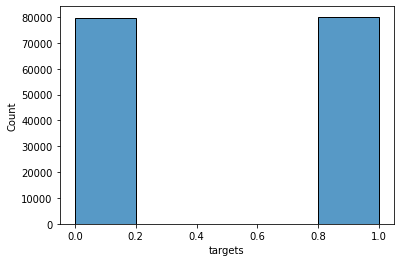

In [6]:
sns.histplot(df, x = "targets", binwidth = 0.2)

# Train and test data split

In [7]:
df_train = df.sample(frac = 0.8, random_state = 1)
df_valid = df[~df.id.isin(df_train.id)]
df_test = df_valid.sample(frac = 0.5, random_state = 1)
df_valid = df_valid[~df_valid.id.isin(df_test.id)]

# Data preprocessing

In [8]:
text_processer = TextProcessor()
df_cleaned_text = df_train.copy()
df_cleaned_text['text'] = df_cleaned_text.text.apply(lambda x: text_processer.clean(x))

In [14]:
pos_words = np.concatenate(df_cleaned_text[df_cleaned_text.targets == 1].text.values).ravel()
neg_words = np.concatenate(df_cleaned_text[df_cleaned_text.targets == 0].text.values).ravel()
total_words = np.concatenate(df_cleaned_text.text.values).ravel()
num_total_words = len(set(total_words))
num_pos_words = len(pos_words)
num_neg_words = len(neg_words)

In [10]:
pos_dict = utils.create_dict(pos_words)
neg_dict = utils.create_dict(neg_words)

In [18]:
def compute_lambda(text, pos_dict, neg_dict, num_total_words, num_pos_words, num_neg_words):
    lambda_ = 0
    denominator_pos = num_total_words + num_pos_words
    denominator_neg = num_total_words + num_neg_words
    for word in text:
        prob_pos = 0
        prob_neg = 0
        if word in pos_dict:
            prob_pos = pos_dict[word]
        if word in neg_dict:
            prob_neg = neg_dict[word]
        prob_pos = (prob_pos + 1) / denominator_pos
        prob_neg = (prob_neg + 1) / denominator_neg
        lambda_ += np.log(prob_pos/prob_neg)
    priolog = np.log(num_pos_words/num_neg_words)
    
    return lambda_+priolog
        

In [19]:
df_test["pred"] = df_test["text"].apply(lambda x: compute_lambda(x, pos_dict, neg_dict, num_total_words, num_pos_words, num_neg_words))

In [22]:
df_test["pred_targets"] = df_test["pred"] > 0

# performance on test data

In [48]:
i = 1011
print(df_test.text.iloc[i], '\n', df_test.targets.iloc[i], '\n', df_test.pred.iloc[i])

The brush isn't really soft and the aplication isn't really even  Oh well, I will work it out. At least the product is great! 
 0 
 -4.570535097710229


In [28]:
(df_test.pred_targets.values == df_test.targets.values).sum()/len(df_test.targets.values)

0.514316079019755

In [29]:
df_train["pred"] = df_train["text"].apply(lambda x: compute_lambda(x, pos_dict, neg_dict, num_total_words, num_pos_words, num_neg_words))

In [30]:
df_train["pred_targets"] = df_train["pred"] > 0

In [31]:
(df_train.pred_targets.values == df_train.targets.values).sum()/len(df_train.targets.values)

0.516296875